In [2]:
%pip install pydantic datasets locust gradio 

In [3]:
from pydantic import BaseModel
from typing import List
import requests

class NERRequest(BaseModel):
    text: str

class Entity(BaseModel):
    entity: str
    score: float
    start: int
    end: int
    word: str

class NERResponse(BaseModel):
    entities: List[Entity]

NER_API_URL = "http://127.0.0.1:8000"
NER_API_URL = "https://lampofsocrates-hf-gradio-plodcw-group27:7860"

In [8]:
from datasets import load_dataset , DownloadMode
import random 
datCW = load_dataset("surrey-nlp/PLOD-CW", download_mode=DownloadMode.REUSE_DATASET_IF_EXISTS)

Found cached dataset parquet (C:/Users/soura/.cache/huggingface/datasets/surrey-nlp___parquet/surrey-nlp--PLOD-CW-843ef47e3e665cc1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

In [11]:

def pick_random_payload():
    global datCW
    idx = random.randint(0, len(datCW["test"])-1)
    tokens = datCW["test"][idx]["tokens"]
    payload = ' '.join(tokens)
    print(payload)
    return payload

pick_random_payload()


( left panel ) Spectrophotometric reading value ( A450 ) represents NF - κB p65 activity .


'( left panel ) Spectrophotometric reading value ( A450 ) represents NF - κB p65 activity .'

## Single Request

In [16]:


# URL of the FastAPI server
url = f"https://huggingface.co/spaces/LampOfSocrates/hf_gradio_plodcw_group27/predict"

# Create an instance of NERRequest
request_data = NERRequest(text=pick_random_payload()) # Pick from PLOD-CW

# Convert the request data to a JSON string
request_json = request_data.json()

# Make the POST request
response = requests.post(url, data=request_json, headers={"Content-Type": "application/json"})


# Check if the request was successful
if response.status_code == 200:
    # Parse the response JSON to the NERResponse model
    ner_response = NERResponse(**response.json())
    print(ner_response)
else:
    print(f"Request failed with status code {response.status_code}")

HPD , human population density .


C:\Users\soura\AppData\Local\Temp\ipykernel_8020\832059799.py:8: PydanticDeprecatedSince20: The `json` method is deprecated; use `model_dump_json` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.5/migration/
  request_json = request_data.json()


ConnectTimeout: HTTPConnectionPool(host='10.25.188.70', port=80): Max retries exceeded with url: /predict (Caused by ConnectTimeoutError(<urllib3.connection.HTTPConnection object at 0x000001A11B8D4E90>, 'Connection to 10.25.188.70 timed out. (connect timeout=None)'))

## Single Request to /hello Endpoint

In [21]:
import requests

# URL of the FastAPI server
url = f"https://lampofsocrates-hf_gradio_plodcw_group27.hf.space:7860/hello"

# Make the GET request
response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
    # Print the response JSON
    print(response.json())
else:
    print(f"Request failed with status code {response.status_code}")

ConnectTimeout: HTTPSConnectionPool(host='lampofsocrates-hf_gradio_plodcw_group27.hf.space', port=7860): Max retries exceeded with url: /hello (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001A11B91A2D0>, 'Connection to lampofsocrates-hf_gradio_plodcw_group27.hf.space timed out. (connect timeout=None)'))

## Multiple request to /ner endpoint

In [62]:
import threading
import time
import pandas as pd
from gradio_client import Client

# List to store the time taken for each request
times = []

# Lock to ensure thread-safe operations on the times list
lock = threading.Lock()

# Function to send a request to the API and measure time taken
def send_request():
    start_time = time.time()

    # Create an instance of NERRequest
    request_data = NERRequest(text="Hello, world!")

    # Convert the request data to a JSON string
    request_json = request_data.json()

    # Make the POST request
    response = requests.post(url, data=request_json, headers={"Content-Type": "application/json"})

    end_time = time.time()
    time_taken = end_time - start_time

    # Append the time taken to the list in a thread-safe manner
    with lock:
        times.append(time_taken)

# Number of concurrent requests
num_requests = 100

# Create threads
threads = []
for _ in range(num_requests):
    thread = threading.Thread(target=send_request)
    threads.append(thread)

# Start threads
for thread in threads:
    thread.start()

# Wait for all threads to complete
for thread in threads:
    thread.join()

# Create a pandas DataFrame with the times
df = pd.DataFrame(times, columns=["Time Taken"])

# Print the describe of the time distribution
print(df.describe())


       Time Taken
count  100.000000
mean     0.018420
std      0.008319
min      0.002018
25%      0.012080
50%      0.018285
75%      0.021183
max      0.050951


## Plot the distribution of times

In [63]:
df["Time Taken"]

0     0.010957
1     0.013984
2     0.008043
3     0.013479
4     0.007442
        ...   
95    0.029726
96    0.032254
97    0.028206
98    0.030225
99    0.020141
Name: Time Taken, Length: 100, dtype: float64

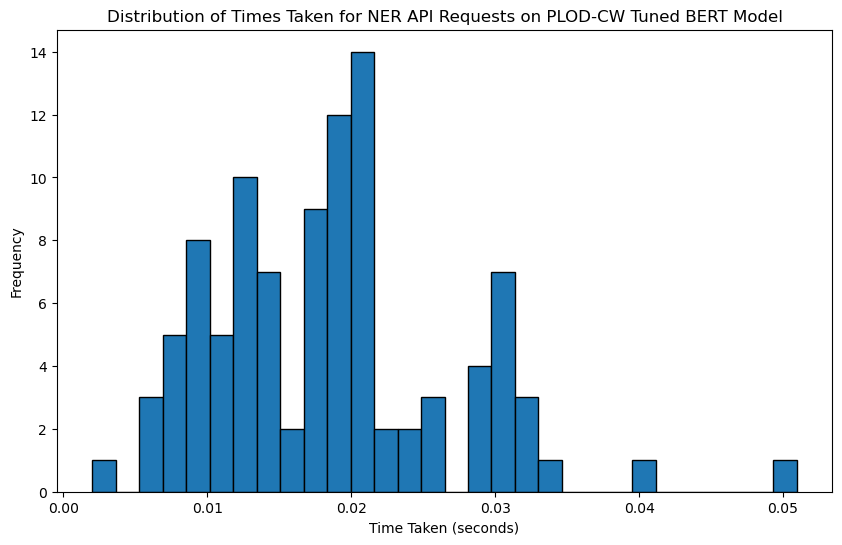

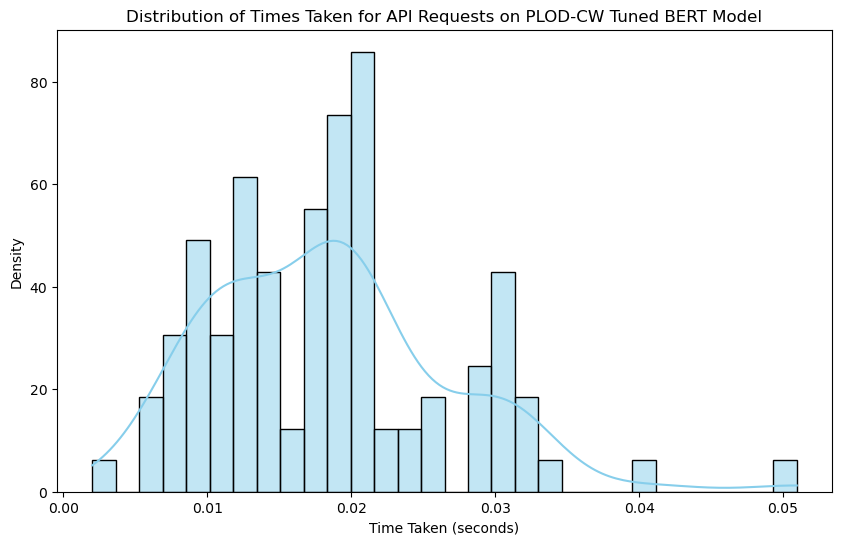

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
# Plot the times taken
plt.figure(figsize=(10, 6))
plt.hist(times, bins=30, edgecolor='black')
plt.title("Distribution of Times Taken for NER API Requests on PLOD-CW Tuned BERT Model")
plt.xlabel("Time Taken (seconds)")
plt.ylabel("Frequency")
plt.show()

# Plot the KDE distribution and histogram of the times taken
# Plot the histogram and KDE distribution of the times taken
plt.figure(figsize=(10, 6))
sns.histplot(df["Time Taken"], kde=True, bins=30, color='skyblue', stat='density', edgecolor='black')
plt.title("Distribution of Times Taken for API Requests on PLOD-CW Tuned BERT Model")
plt.xlabel("Time Taken (seconds)")
plt.ylabel("Density")
plt.show()